# Who will win your fantasy football league? 

If your fantasy football league does not automatically give you playoff odds (like my Yahoo facilitated league) then you may be wondering how screwed you are with your slow start to the season. Fortunately, by utilizing some basic machine learning principles we can get a good idea of each teams playoff chances with relative ease (given that we're willing to assume that past performance is generally predictive of future performance by team). The approach taken here will be to generate a posterior gaussian distribution of weekly point total for each individual team using a pooled prior distribution. The prior will be a gaussian distribution generated either by the previous season's weekly point totals for each team, or the current season's weekly point totals for each team. By using a conjugate prior analysis we can use a team's current season weekly point totals as a likelihood, update our priors and generate a fast predictive posterior distribution. 

After getting each team's posterior distribution for points we can simulate an entire season by drawing each team's points from those posterior predictive gaussian distributions and then tallying the results of each game. We'll do this, seed the playoffs using each team's final record and point totals and then simulate each playoff game to get a simulated champion. By doing this hundreds or thousands of time, tallying the amount of times each team makes the playoffs and wins the championship, we can get a good idea of what each team's playoff and championship chances are. 

In [26]:
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import itertools

## Import & Process Data

Data must be formatted as a csv with a single matchup in each row as shown below. Each game must be shown here even if it has not yet been played. The games without points will be used to simulate the rest of the season while the completed games will be used as datapoints for our distributions and will also be used to generate current win-loss records.

In [27]:
data = pd.read_csv('fantasy_data.csv')
data

,week,team1,team2,pts1,pts2
0,1,Ph Phor Phendetta,Cardinals Fan,132.26,108.52
1,1,Dad Bod,EPICdemic,125.34,95.08
2,1,Mischief Managed,Chalupa Batman,129.58,102.04
3,1,Sore Looza,Coach Roy Kent,137.18,153.74
4,1,Florida?,TheStars&Stripes,84.62,116.54
...,...,...,...,...,...
70,15,Ph Phor Phendetta,TheStars&Stripes,NaN,NaN
71,15,Dad Bod,Chalupa Batman,NaN,NaN
72,15,Mischief Managed,EPICdemic,NaN,NaN
73,15,Sore Looza,Cardinals Fan,NaN,NaN


#### Generate a list of the teams in the league

In [3]:
teams = list(data.team1)
teams.extend(data.team2)
teams = list(set(teams))
teams

['Dad Bod',
 'Coach Roy Kent',
 'Chalupa Batman',
 'Cardinals Fan',
 'Sore Looza',
 'EPICdemic',
 'TheStars&Stripes',
 'Florida?',
 'Ph Phor Phendetta',
 'Mischief Managed']

#### Generate a datafame of points by team

By getting each team's weekly points into a separate column we will be able to easily call on each team's data to generate a likelihood distribution. 

In [4]:
def get_team_points(data):
    temp_pts = data.dropna()
    max_week = temp_pts.week.max()
    v = temp_pts.week.max()
    temp1 = temp_pts[['week','team1','pts1']].rename({'team1':'team','pts1':'pts'}, axis=1)
    temp2 = temp_pts[['week','team2','pts2']].rename({'team2':'team','pts2':'pts'}, axis=1)
    temp = pd.concat([temp1,temp2])
    df = pd.pivot(data=temp, index='week',columns='team',values='pts').reset_index()
    df = df.drop(columns=['week'])
    return df

df = get_team_points(data)
df

team,Cardinals Fan,Chalupa Batman,Coach Roy Kent,Dad Bod,EPICdemic,Florida?,Mischief Managed,Ph Phor Phendetta,Sore Looza,TheStars&Stripes
0,108.52,102.04,153.74,125.34,95.08,84.62,129.58,132.26,137.18,116.54
1,115.80,100.88,68.02,101.06,109.32,102.80,126.48,144.80,142.10,99.90
2,111.98,121.96,68.02,125.38,96.28,112.88,124.54,108.26,80.88,104.50
3,118.26,99.42,104.06,114.42,148.42,134.86,135.32,98.40,127.00,83.88
4,194.46,113.80,107.70,93.82,128.54,110.36,122.90,127.92,138.18,125.96
5,91.54,131.68,95.58,112.50,95.84,111.94,138.56,94.56,131.80,111.56
6,126.72,96.64,104.88,65.06,151.96,95.22,127.14,110.22,97.60,107.00
7,106.48,105.70,109.42,87.40,71.36,70.20,134.56,91.32,85.58,93.04
8,95.22,106.78,123.70,77.78,78.40,109.62,77.84,79.36,70.00,122.90
9,82.42,94.06,98.24,148.98,95.12,96.58,76.56,65.22,101.10,94.56


#### Get each team's current record

This will allow us to add simulated game results to the previous results of the league

In [5]:
def get_records(data):
    temp_pts = data.dropna()
    max_week = temp_pts.week.max()
    temp_pts['winner'] = [temp_pts.team1.loc[i] if temp_pts.pts1.loc[i] > temp_pts.pts2.loc[i] else temp_pts.team2.loc[i] for i in range(len(temp_pts))]
    records = temp_pts.winner.value_counts().reset_index().rename({'index':'Team','winner':'W'},axis=1)
    records['L'] = max_week - records.W 
    pts = []
    for team in records.Team:
        pts.append(df[team].sum())
    records['pts'] = pts
    records = records.sort_values(['W','pts'], ascending = False).reset_index(drop=True)
    return records

records = get_records(data)
records

<ipython-input-5-1a5ea24ad026>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_pts['winner'] = [temp_pts.team1.loc[i] if temp_pts.pts1.loc[i] > temp_pts.pts2.loc[i] else temp_pts.team2.loc[i] for i in range(len(temp_pts))]


,Team,W,L,pts
0,Mischief Managed,8,2,1193.48
1,Ph Phor Phendetta,7,3,1052.32
2,TheStars&Stripes,6,4,1059.84
3,Dad Bod,6,4,1051.74
4,Cardinals Fan,5,5,1151.40
5,Sore Looza,5,5,1111.42
6,Florida?,5,5,1029.08
7,Coach Roy Kent,4,6,1033.36
8,EPICdemic,3,7,1070.32
9,Chalupa Batman,1,9,1072.96


#### Get Schedule

In [6]:
def get_schedule(data): 
    schedule = data[data.pts1.isna()].drop(columns=['pts1','pts2']).reset_index(drop=True)
    return schedule

schedule = get_schedule(data)
schedule.head()

,week,team1,team2
0,11,Ph Phor Phendetta,Florida?
1,11,Dad Bod,Chalupa Batman
2,11,Mischief Managed,EPICdemic
3,11,Sore Looza,TheStars&Stripes
4,11,Cardinals Fan,Coach Roy Kent


## Generate Likelihood and Posterior Parameters

### Get dictionary of likelihood Gaussian parameters

Generate a dictionary with each team's mean and standard deviation for their performance so far this season

In [30]:
def get_likelihood_dict(teams):

    team_dict = {}
    for team in teams:
        mean = round(df[team].mean(),3)
        std = round(df[team].std(),3)
        team_dict[team] = [mean,std]

    return team_dict

team_dict = get_likelihood_dict(teams)
team_dict

{'Cardinals Fan': [115.14, 30.892],
 'Chalupa Batman': [107.296, 11.899],
 'Coach Roy Kent': [103.336, 24.933],
 'Dad Bod': [105.174, 25.154],
 'EPICdemic': [107.032, 27.522],
 'Florida?': [102.908, 17.657],
 'Mischief Managed': [119.348, 22.767],
 'Ph Phor Phendetta': [105.232, 24.652],
 'Sore Looza': [111.142, 27.063],
 'TheStars&Stripes': [105.984, 13.559]}

### Get posterior gaussian parameters using the entire league as a prior

In [31]:
def get_points(team1, team2, df):
    # Set Priors
    mu0 = round(np.array(df).mean(),3)
    sig0 = round(np.array(df).std(),3)

    mu = round(df[team1].mean(),3)
    sig = round(df[team1].std(),3)

    muN1 = round((mu0*sig**2 + len(df)*mu*sig0**2)/(sig**2 + len(df)*sig0**2),3)
    sigN1 = round((((sig0**2)*(sig**2))/(sig**2 + len(df)*sig0**2))**0.5, 3)
    sigNpred1 = (sig**2 + sigN1**2)**0.5
    
    mu = round(df[team2].mean(),3)
    sig = round(df[team2].std(),3)

    muN2 = round((mu0*sig**2 + len(df)*mu*sig0**2)/(sig**2 + len(df)*sig0**2),3)
    sigN2 = round((((sig0**2)*(sig**2))/(sig**2 + len(df)*sig0**2))**0.5, 3)
    sigNpred2 = (sig**2 + sigN2**2)**0.5

    pts1 = (round(random.normal(muN1, sigNpred1),3))
    pts2 = (round(random.normal(muN2, sigNpred2),3))
    
    return pts1, pts2

get_points('Ph Phor Phendetta','Cardinals Fan', df=df)

(106.007, 92.711)

In [9]:
records_dict = {}
for team in teams:
    query = F"Team == '{team}'"
    wins = records.query(query).W.reset_index(drop=True).loc[0]
    losses = records.query(query).L.reset_index(drop=True).loc[0]
    pts = records.query(query).pts.reset_index(drop=True).loc[0]
    records_dict[team] = [wins,losses,pts]

### Simulate a season

In [10]:
def sim_season(data, schedule, team_dict, bayes=False):
    df = get_team_points(data)
    v = data.dropna().week.max()
    records_dict = {}
    for team in teams:
        query = F"Team == '{team}'"
        wins = records.query(query).W.reset_index(drop=True).loc[0]
        losses = records.query(query).L.reset_index(drop=True).loc[0]
        pts = records.query(query).pts.reset_index(drop=True).loc[0]
        records_dict[team] = [wins,losses,pts]

    for i in range(len(schedule)):
        team1 = schedule.loc[i].team1
        team2 = schedule.loc[i].team2
                
        if not bayes:
            pts1 = round(team_dict[team1][1]*random.standard_t(df=v) + team_dict[team1][0],3)
            pts2 = round(team_dict[team2][1]*random.standard_t(df=v) + team_dict[team2][0],3)
        else:
            pts1, pts2 = get_points(team1, team2, df=df)

        records_dict[team1][2]  = round(pts1 + records_dict[team1][2],2)
        records_dict[team2][2]  = round(pts2 + records_dict[team2][2],2)

        if pts1 > pts2:
            records_dict[team1][0] += 1
            records_dict[team2][1] += 1
        else:
            records_dict[team2][0] += 1
            records_dict[team1][1] += 1


    return records_dict

records_dict = sim_season(data=data, schedule=schedule, team_dict=team_dict, bayes=True)
records_dict

{'Cardinals Fan': [7, 8, 1713.05],
 'Chalupa Batman': [3, 12, 1598.82],
 'Coach Roy Kent': [7, 8, 1543.35],
 'Dad Bod': [7, 8, 1565.92],
 'EPICdemic': [5, 10, 1546.44],
 'Florida?': [7, 8, 1582.77],
 'Mischief Managed': [13, 2, 1788.7],
 'Ph Phor Phendetta': [9, 6, 1587.98],
 'Sore Looza': [8, 7, 1675.43],
 'TheStars&Stripes': [9, 6, 1593.35]}

### Seed the playoffs

In [11]:
def seed_playoffs(records_dict):
    wins, losses, pts = [],[],[]

    for team in teams:
        wins.append(records_dict[team][0])
        losses.append(records_dict[team][1])
        pts.append(records_dict[team][2])

    standings = pd.DataFrame({
        'team':teams,
        'wins':wins,
        'losses':losses,
        'points':pts
    })

    standings = standings.sort_values(by=['wins','points'], ascending=False).reset_index(drop=True)
    return standings

### Simulate the playoffs

In [12]:
def simulate_playoffs(data, standings, championship_dict):
    v = data.dropna().week.max()

    seed1 = standings.team.loc[0]
    seed2 = standings.team.loc[1]
    seed3 = standings.team.loc[2]
    seed4 = standings.team.loc[3]

    championship = []
    consolation = []

    # Seed 1 v Seed 4
    pts1 = round(team_dict[seed1][1]*random.standard_t(df=v) + team_dict[seed1][0],3)
    pts4 = round(team_dict[seed4][1]*random.standard_t(df=v) + team_dict[seed4][0],3)

    if pts1 > pts4:
        championship.append(seed1)
        consolation.append(seed4)
    else:
        championship.append(seed4)
        consolation.append(seed1)

    # Seed 2 v Seed 3
    pts2 = round(team_dict[seed2][1]*random.standard_t(df=v) + team_dict[seed2][0],3)
    pts3 = round(team_dict[seed3][1]*random.standard_t(df=v) + team_dict[seed3][0],3)

    if pts2 > pts3:
        championship.append(seed2)
        consolation.append(seed3)
    else:
        championship.append(seed3)
        consolation.append(seed2)

    # Championship Game
    pts1 = round(team_dict[championship[0]][1]*random.standard_t(df=v) + team_dict[championship[0]][0],3)
    pts2 = round(team_dict[championship[1]][1]*random.standard_t(df=v) + team_dict[championship[1]][0],3)

    if pts1 > pts2:
        championship_dict[championship[0]][0] += 1
        championship_dict[championship[1]][1] += 1
    else:
        championship_dict[championship[1]][0] += 1
        championship_dict[championship[0]][1] += 1

    # Consolation Game
    pts1 = round(team_dict[consolation[0]][1]*random.standard_t(df=v) + team_dict[consolation[0]][0],3)
    pts2 = round(team_dict[consolation[1]][1]*random.standard_t(df=v) + team_dict[consolation[1]][0],3)

    if pts1 > pts2:
        championship_dict[consolation[0]][2] += 1
        championship_dict[consolation[1]][3] += 1
    else:
        championship_dict[consolation[1]][2] += 1
        championship_dict[consolation[0]][3] += 1

    return championship_dict

# Run the simulation

In [13]:
iterations = 10000
bayes=True

wins_dict = {}
for team in teams:
    wins_dict[team] = []

championship_dict = {}
for team in teams:
    championship_dict[team]=[0,0,0,0]
    
for i in range(iterations):
    if i % 100 == 0:
        print(i, end=", ")
    records_dict = sim_season(data=data, schedule=schedule, team_dict=team_dict, bayes=bayes)
    standings = seed_playoffs(records_dict=records_dict)
    champioship_dict = simulate_playoffs(data=data,standings=standings, championship_dict=championship_dict)
    
    for team in teams:
        wins_dict[team].append(records_dict[team][0])
    
championship_dict

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 

{'Cardinals Fan': [1393, 1234, 1315, 1036],
 'Chalupa Batman': [0, 0, 0, 0],
 'Coach Roy Kent': [136, 163, 204, 275],
 'Dad Bod': [905, 1382, 1308, 1657],
 'EPICdemic': [22, 32, 47, 53],
 'Florida?': [200, 334, 415, 512],
 'Mischief Managed': [3960, 2353, 2360, 1298],
 'Ph Phor Phendetta': [1489, 2184, 2000, 2523],
 'Sore Looza': [940, 974, 1030, 917],
 'TheStars&Stripes': [955, 1344, 1321, 1729]}

# Plot the data

In [14]:
firsts = []
seconds = []
thirds = []
fourths = []

for team in teams:
    firsts.append(championship_dict[team][0]/iterations)
    seconds.append(championship_dict[team][1]/iterations)
    thirds.append(championship_dict[team][2]/iterations)
    fourths.append(championship_dict[team][3]/iterations)
    
results_df = pd.DataFrame({
    'team':teams,
    'first':firsts,
    'second':seconds,
    'third':thirds,
    'fourth':fourths
})

results_df = results_df.melt(id_vars='team',value_vars=['first','second','third','fourth'], value_name='probability',var_name='place')
results_df.head()

,team,place,probability
0,Cardinals Fan,first,0.1393
1,Chalupa Batman,first,0.0000
2,Coach Roy Kent,first,0.0136
3,Dad Bod,first,0.0905
4,EPICdemic,first,0.0022


Text(0.5, 1.0, 'Probability of End of Season Place by Team')

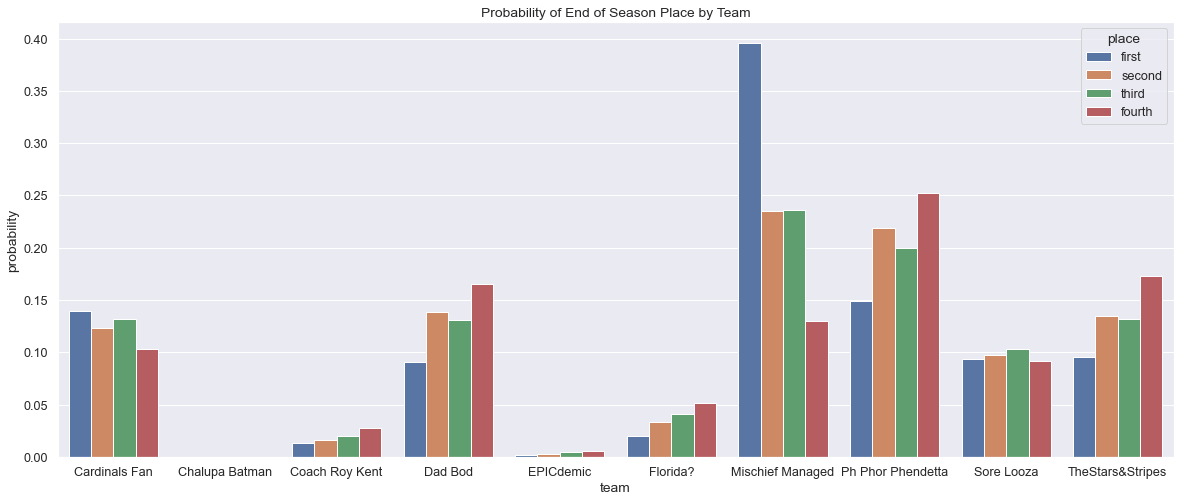

In [15]:
sns.set(rc = {'figure.figsize':(20,8)}, font_scale=1.15)
g = sns.barplot(data=results_df, x='team', y='probability',hue='place')
g.set_title("Probability of End of Season Place by Team")

,team,place,probability
6,Mischief Managed,first,0.3960
7,Ph Phor Phendetta,first,0.1489
0,Cardinals Fan,first,0.1393
9,TheStars&Stripes,first,0.0955
8,Sore Looza,first,0.0940
3,Dad Bod,first,0.0905
5,Florida?,first,0.0200
2,Coach Roy Kent,first,0.0136
4,EPICdemic,first,0.0022
1,Chalupa Batman,first,0.0000


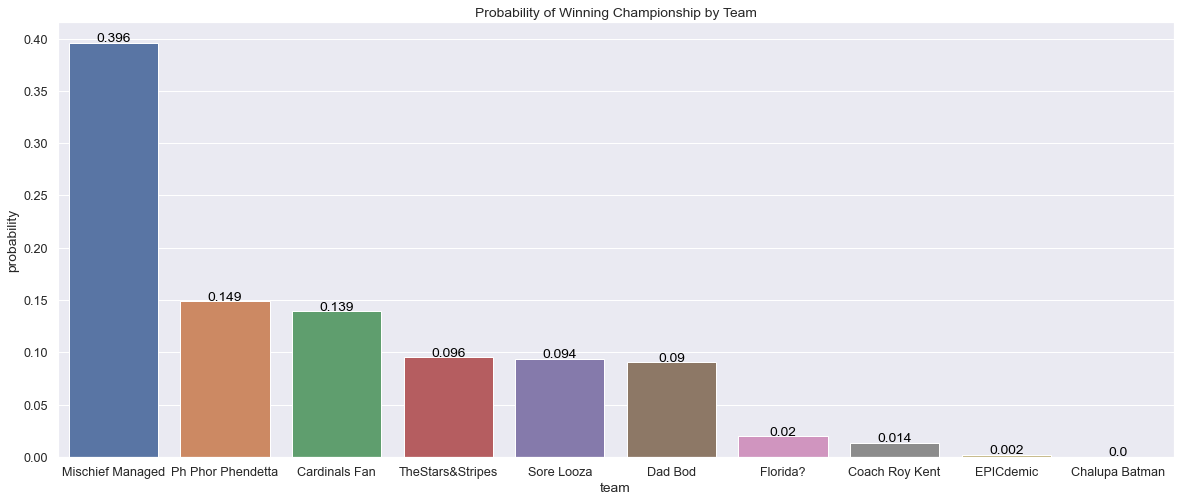

In [16]:
df_win = results_df.query("place == 'first'").sort_values('probability', ascending=False)
g = sns.barplot(data=df_win, x='team',y='probability')
g.set_title("Probability of Winning Championship by Team")
count = 0
for index, row in df_win.iterrows():
    g.text(count,row.probability+.001, round(row.probability,3), color='black', ha="center")
    count += 1
df_win

,team,probability
0,Mischief Managed,0.9971
1,Ph Phor Phendetta,0.8196
2,TheStars&Stripes,0.5349
3,Dad Bod,0.5252
4,Cardinals Fan,0.4978
5,Sore Looza,0.3861
6,Florida?,0.1461
7,Coach Roy Kent,0.0778
8,EPICdemic,0.0154
9,Chalupa Batman,0.0000


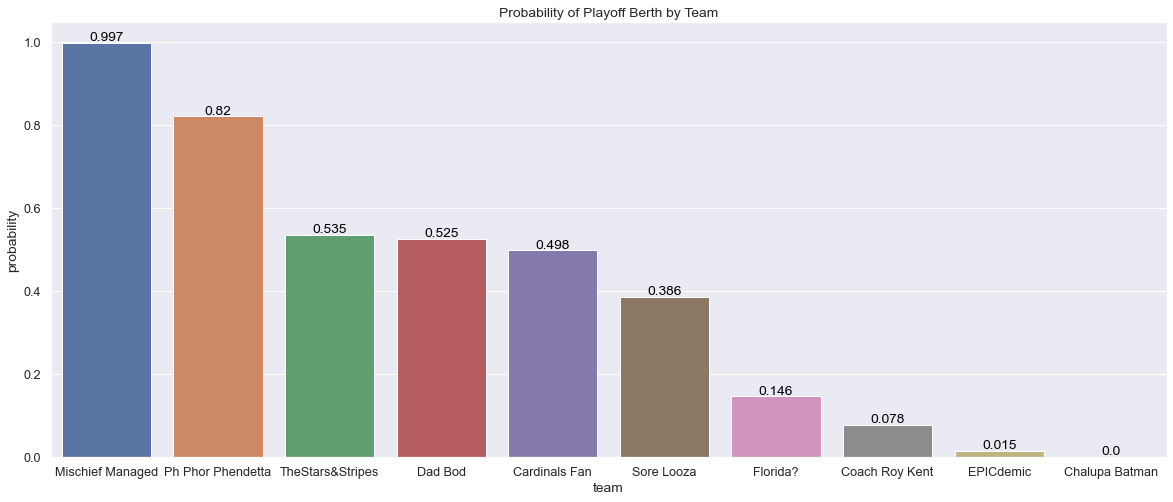

In [17]:
df_poff = results_df.groupby('team').sum().sort_values('probability', ascending=False).reset_index(drop=False)
df_poff
g = sns.barplot(data=df_poff, x='team',y='probability')
g.set_title("Probability of Playoff Berth by Team")
count = 0
for index, row in df_poff.iterrows():
    g.text(count,row.probability+.005, round(row.probability,3), color='black', ha="center")
    count += 1
df_poff

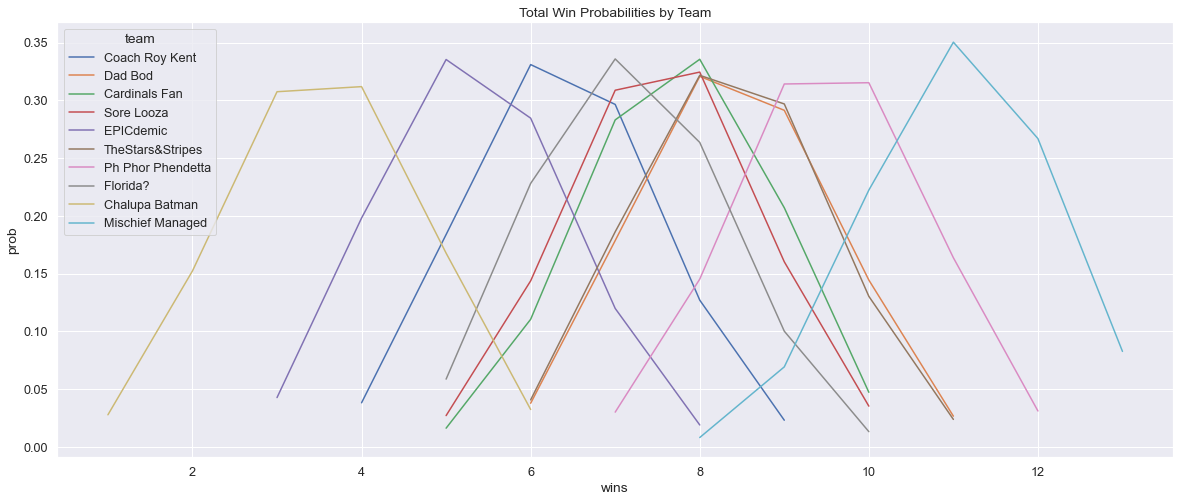

In [18]:
wins = []
teams = []

for team in wins_dict.keys():
    wins.extend(wins_dict[team])
    for i in wins_dict[team]:
        teams.append(team)
        
wins_df = pd.DataFrame({
    'team':teams,
    'wins':wins
})

df_agg = pd.DataFrame()
for team in set(wins_df.team):
    win_counts = pd.DataFrame(wins_df.query(F"team == '{team}'").wins.value_counts()).reset_index().rename({'index':'wins','wins':'count'}, axis=1)
    win_counts['prob'] = win_counts['count']/(win_counts['count'].sum())
    win_counts['team'] = team
    df_agg = pd.concat([df_agg, win_counts]).reset_index(drop=True)
    
filt = False
if filt:
    team_filter = ['Mischief Managed','Ph Phor Phendetta','TheStars&Stripes','Cardinals Fan']
    sns.lineplot(data=df_agg[df_agg.team.isin(team_filter)], x='wins', y='prob', hue='team').set_title("Total Win Probabilities by Team")
else:
    sns.lineplot(data=df_agg, x='wins', y='prob', hue='team').set_title("Total Win Probabilities by Team")


In [19]:
df_max = pd.DataFrame()
for team in set(df_agg.team):
    df_temp = pd.DataFrame(df_agg.query(F"team == '{team}'").sort_values('prob', ascending=False).reset_index(drop=True).loc[0]).transpose()
    df_max = pd.concat([df_max, df_temp]).reset_index(drop=True)    
df_max = df_max.sort_values('wins', ascending=False).reset_index(drop=True)
df_max

,wins,count,prob,team
0,11,3505,0.3505,Mischief Managed
1,10,3154,0.3154,Ph Phor Phendetta
2,8,3209,0.3209,Dad Bod
3,8,3357,0.3357,Cardinals Fan
4,8,3246,0.3246,Sore Looza
5,8,3218,0.3218,TheStars&Stripes
6,7,3360,0.336,Florida?
7,6,3311,0.3311,Coach Roy Kent
8,5,3355,0.3355,EPICdemic
9,4,3120,0.312,Chalupa Batman


# Carly's chances of winning each of her games

In [20]:
get_points('Mischief Managed','Ph Phor Phendetta', df=df)

(131.34, 138.154)

In [21]:
def get_team_odds(team):
    carly = team
    carly_sched = schedule.query(F"(team1 == '{carly}') | (team2 == '{carly}')")
    opponents = [team for team in carly_sched.team1 if team != carly]
    opponents.extend([team for team in carly_sched.team2 if team != carly])

    opp_dict = {}
    for opp in opponents:
        opp_dict[opp] = 0

    tries = 1000
    count = 0
    for opp in set(opponents):
        for i in range(tries):
            if count % 100 == 0:
                print(count, end=", ")
            pts1, pts2 = get_points(carly, opp, df=df)
    #         print(F"Carly beats {opp}")
            if pts1 > pts2:
                opp_dict[opp] += 1
            count += 1

    opps, wins = [], []
    for opp in opp_dict.keys():
        opps.append(opp)
        wins.append(opp_dict[opp])

    carly_df = pd.DataFrame({
        'opp':opps,
        'wins':wins
    })
    carly_df['prob_win'] = carly_df.wins/tries
    carly_df['prob_lose'] = 1-carly_df.prob_win
    return carly_df, opponents

carly_df, opponents = get_team_odds('Mischief Managed')
carly_df

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

,opp,wins,prob_win,prob_lose
0,EPICdemic,617,0.617,0.383
1,Florida?,707,0.707,0.293
2,Sore Looza,580,0.580,0.420
3,Cardinals Fan,556,0.556,0.444


In [22]:
prob_lose_out = 1

for opp in opponents:
    prob_lose_out = prob_lose_out * (carly_df.query(F"opp =='{opp}'").prob_lose.reset_index(drop=True).loc[0])
    
prob_lose_out

0.008014887462960002

In [23]:
def prob_win_out(df):
    prob = 1
    for i in df.prob_win:
        prob = prob*i
    return round(prob,5)

In [24]:
outcomes = [i for i in (set(itertools.permutations([0,0,0,0,0,0,1,1,1,1,1,1],6))) if sum(i) <= 1]

In [25]:
prob_total = 0

for outcome in outcomes:
    prob = 1
    count = 0
    for game in outcome:
        opp = opponents[count]
        
        if game == 1:
            col = 'prob_win'
        if game == 0:
            col = 'prob_lose'
            
        prob = prob * carly_df.query(F"opp == '{opp}'")[col].reset_index(drop=True).loc[0]
        
        count += 1
    prob_total += prob
    
print(F"Probability of Carly winning 1 or 0 games: {round(prob_total,4)}")

IndexError: list index out of range

In [ ]:
team_name = 'Dad Bod'
df_team, opps = get_team_odds(team_name)
print("\n")
print(F"Prob of {team_name} winning out:", prob_win_out(df_team))
df_team

In [ ]:
team_name = 'TheStars&Stripes'
df_team, opps = get_team_odds(team_name)
print("\n")
print(F"Prob of {team_name} winning out:", prob_win_out(df_team))
df_team

In [ ]:
team_name = 'Ph Phor Phendetta'
df_team, opps = get_team_odds(team_name)
print("\n")
print(F"Prob of {team_name} winning out:", prob_win_out(df_team))
df_team